# Solving a System of First Order ODEs with a PINN

A good way to see how to implement a Physics-Informed Neural Network (PINN) to solve a physics-based problem that involves a system of equations, is to do so by example.  After watching this example [1], I created my own Jupyter notebook to replicate that work and continue past it.  The corresponding sysEqns.py file is in work and will be the place where I incorporate the things I learned from this notebook.

[1] https://www.youtube.com/watch?v=gXv1SGoL04c

**Outline**
1. [PINN background](#PINN)
2. [PINN python class definition](#PINN-Class)
    1. [Loss function with ODEs and ICs](#Loss)
    2. [Training function with previous loss definition](#training-function)
    2. [Execute PINN training](#set-up-the-steps-and-execute)
    2. [Define analytical solution](#define-analytical-solution-for-comparison)
    2. [Visualize](#visualize)
3. [Data fitting with PINN](#data-fitting-with-pinn)
    1. [Generate random noise](#now-generate-random-noise-to-similate-real-data)
    3. [Data loss function](#create-the-data-loss-function)
4. [Define new setup](#new-set-up)
    1. [Train on data](#now-retrain-the-pinn-on-the-provided-data)
    4. [Run the new model](#run-the-model)
    4. [Visualize results](#visualize)
5. [Increase training epochs](#now-increase-the-epochs)
    1. [Visualize](#visualize)
6. [Predict last data point](#predict-last-data-point)
    1. [A PINN for last point prediction](#model-a-pinn-class-to-predict-last-data-point)
    6. [Use sequence sliding input window for allowed training data](#use-sequence-sliding-input-window-for-allowed-training-data)
    6. [Use window data gap to ignore data in training](#use-window-data-gap-to-ignore-data-in-training)
    6. [Perform 2-class classification for last point prediction](#perform-2-class-classification-for-last-point-prediction)
    6.[Expand last point prediction to area prediction](#expand-last-point-prediction-to-area-prediction)
    6. [Example probability graph](#example-graph-represent-probabilities)

## PINN
A PINN is a special type of neural network that incorporates the physics within the training process for the neural network.  Traditional neural networks learn to model the data by minimizing a data-fit loss function, but a PINN includes the residuals from the underlying physics differential equations within the loss function.  This allows the PINN model to obey the physics when fitting the data.  The PINN really shines under limited data scenarios because the physics of the equations (ODEs, PDEs) shape the solution.

## Example: A 2-D System of ODEs
Suppose we have these two ODEs and initial conditions (ICs) that describe two coupled harmonic oscillators or electrical circuits for a time domain $t\in [0,5]$:

$$\frac{dx}{dt}=-2x-y$$
$$\frac{dy}{dt}=x-2y$$
$$x(0)=1$$
$$y(0)=0$$

with analytical solutions,

$$x(t)=^1_2\left( e^{-t}+e^{-3t}\right)$$
$$x(t)=^1_2\left( -e^{-t}+e^{-3t}\right)$$

## PINN Key Concept
The idea is to represent the unknown functions $x(t)$ and $y(t)$ as an output of a neural network.  The input of the network is the time $t$ and the network will learn to approximate the functions $x(t)$ and $y(t)$ by minimizing a loss function that includes both of these:
1. The residuals of the ODEs
2. The intial conditions.
By training the neural network to minimize this combined loss, we ensure that the network learns a solution that satisfies both the governing equatinos and the given initial conditions.

## Neural Network Architecture
The NN will have the following structure:
- Input layer with 1 neuron for the input $t$
- Hidden layers with non-linear activation functions (e.g. $Tanh$ or $ReLU$) to learn the underlying structure of the problem
- Output layer to provide the 2 variables we want, $x(t)$ and $y(t)$

The NN will be trained to minimize the residuals of the ODEs and the error in the ICs.

## Loss Function
The most critical part of a NN and especially for the PINN is the way we set up the loss function to satisfy the physics (residuals of the ODEs) and the ICs.
1. ODE Residual Loss
2. IC Loss
The **total loss** is the sum of the two contributions:
$$Total Loss=ODE Residual Loss + IC Loss$$
Variations of the solutions can also include data loss terms and options on how one "adds" the losses, e.g. weighted loss.

### ODE Residual Loss
Rearranging the ODEs so that they sum to zero will put the ODEs into a *residual loss* format as shown here:
$$f_x(t)=\frac{dx}{dt}+2x+y$$
$$f_y(t)=\frac{dy}{dt}-x+2y$$
These are embedded into the PINN as residuals to minimize.  The NN output should minimize the residuals to satisfy the ODEs at each point in the domain $t$.
To measure the residual loss between ODEs and data points, we will use the *mean squared sum error*:
$$MSE(f_x(t))=\frac{1}{N}\sum^N_{i=1}(f_x(t_i))^2$$
$$MSE(f_y(t))=\frac{1}{N}\sum^N_{i=1}(f_y(t_i))^2$$
- The MSE penalizes any deviation of the network's output from satisfying the ODEs.
- The NN is trained to minimize the residuals.

### IC Loss
To satisfy the ICs, we rearrange them into loss terms:
$$IC_x=(x(0)-1)^2 \text{and} IC_y=(y(0)-0)^2=(y(0))^2$$
- The IC losses ensure that the NN solution satisfies the ICs.
- The NN is penalized heavily for not satisfying the ICs.

### Total Loss Function
The *total loss function* is simply the sum of all the losses.  Alternatively, the architect can unequally weight these losses.
$$TLF=MSE(f_x(t))+MSE(f_y(t))+IC_x+IC_y$$
- $MSE_x$ satisfies $f_x(t)$
- $MSE_y$ satisfies $f_y(t)$
- $IC_x$ satisfies $x(0)=1$
- $IC_y$ satisfies $y(0)=0$

## Role of Collection Points
Collection points are specific points ($t_i$) where we enforce ODEs and ICs (and/or BCs).
- These points are siilar to data points in traditional machine learning because we generate the data at these points.
- Ensures the system of ODEs is satisfied throughout the domain.
- Often chosen to be evenly spaced throughout the domain to provide a uniform representation of the problem space.

## Universal Approximation Theorem
The UAT simply states that a simple NN with enough neurons in the hidden layers and suitable activation functions can approximate any continuous function on a closed and bounded interval to any desired level of accuracy.

## Training the NN
The NN is trained by minimizing the total loss function (TLF) during each epoch of training.
1. NN predicts $x$ and $y$ at various $t$
2. $\dot{x}$ and $\dot{y}$ are computed with automatic differentiation
3. The ODE residuals are calculated
4. The TLF is evaluated; gradients are computed to update the NN weights that minimize the TLF (e.g. gradient descent method)
5. Over time (epochs), the NN learns the satisfy the ODEs and the ICs.

## Implementation
1. Define NN architecture
2. Define loss function
3. Train the NN on the data
4. Evaluate the NN outputs
5. Visualize the results

# Python Code
## Imports (system setup)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

## PINN Class

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh()
        )
        self.dense2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh()
        )
        self.dense3 = nn.Linear(64, 2)  # Outputs x(t), y(t)

    def forward(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        return self.dense3(t)


## Loss 
Key steps:
1. Compute the gradient for NN's estimate of $\frac{dx}{dt}$ and $\frac{dy}{dt}$
2. Compute the ODE residuals

In [3]:
def loss_fn(model, t):
    """ Total Loss Function """
    # Enable gradient tracking
    t.requires_grad_(True)

    # Forward pass
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # Compute gradients dx/dt and dy/dt
    dxdt = torch.autograd.grad(outputs=x, inputs=t,
                                grad_outputs=torch.ones_like(x),
                                create_graph=True)[0]
    dydt = torch.autograd.grad(outputs=y, inputs=t,
                                grad_outputs=torch.ones_like(y),
                                create_graph=True)[0]

    # Residual ODEs
    res_x = dxdt + 2 * x + y
    res_y = dydt + x + 2 * y

    # Initial Conditions (IC)
    ICx = (x[0] - 1) ** 2
    ICy = (y[0] - 0) ** 2

    # Total loss
    loss = (torch.mean(res_x ** 2) +
            torch.mean(res_y ** 2) +
            ICx + ICy)

    return loss


## Training function
The key steps are:
1. Epoch loop - update the model weights in each epoch
2. Calculate the loss with a goal to exit loop when loss is $\lt 10^{-3}$ or $\lt 10^{-4}$
3. Calculate the gradient of the loss with respect to the NN weights and NN biases
4. Update the optimizer to update the model parameters so that the loss is further reduced
5. Log the progress

In [4]:
def train(model, t, epochs, optimizer):
    for epoch in range(epochs):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the loss
        loss = loss_fn(model, t)
        
        # Backpropagation
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Print loss periodically
        if epoch % 500 == 0:
            print(f"Epoch {epoch} Loss: {loss.item()}")


## Set up the steps and Execute
1. Define our model with the PINN class
2. Define the gradient optimizer, e.g. **Adam**, to control the learning rate for the model's weights during training.
3. Loop the model and optimizer to adjust the model parameters to minimize the loss and ensure the NN satisfies both the physics and the ICs.

In [5]:
# Run our model
model = PINN()

# Define the optimizer
# optimizer = tf.keras.optimizer.Adam(learning_rate=0.001) # control rate
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Control rate

# Define domain (t ∈ [0, 5]) -- "Collection Points"
# t = tf.convert_to_tensor(np.linspace(0,5,100)[:, None], dtype=tf.float32)
t = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)

# Train the model
train(model, t, epochs=4000, optimizer=optimizer)

# Test the model
t_test = torch.tensor(np.linspace(0, 5, 300).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_test)
    x_pred, y_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()


Epoch 0 Loss: 1.781045913696289
Epoch 500 Loss: 0.00025849477970041335
Epoch 1000 Loss: 2.8116643079556525e-05
Epoch 1500 Loss: 1.0261219358653761e-05
Epoch 2000 Loss: 5.100710495753447e-06
Epoch 2500 Loss: 3.1248016512108734e-06
Epoch 3000 Loss: 2.3470543055736925e-06
Epoch 3500 Loss: 1.80534311766678e-06


## Define analytical solution for comparison

In [6]:
# Truth solution
def solution(t):
    t = np.asarray(t)  # Ensure it's a standard ndarray
    x_t = 0.5 * (np.exp(-t) + np.exp(-3*t))
    y_t = 0.5 * (-1*np.exp(-t) + np.exp(-3*t))
    return x_t, y_t

# Compare results:
x_true, y_true = solution(t_test)


## Visualize

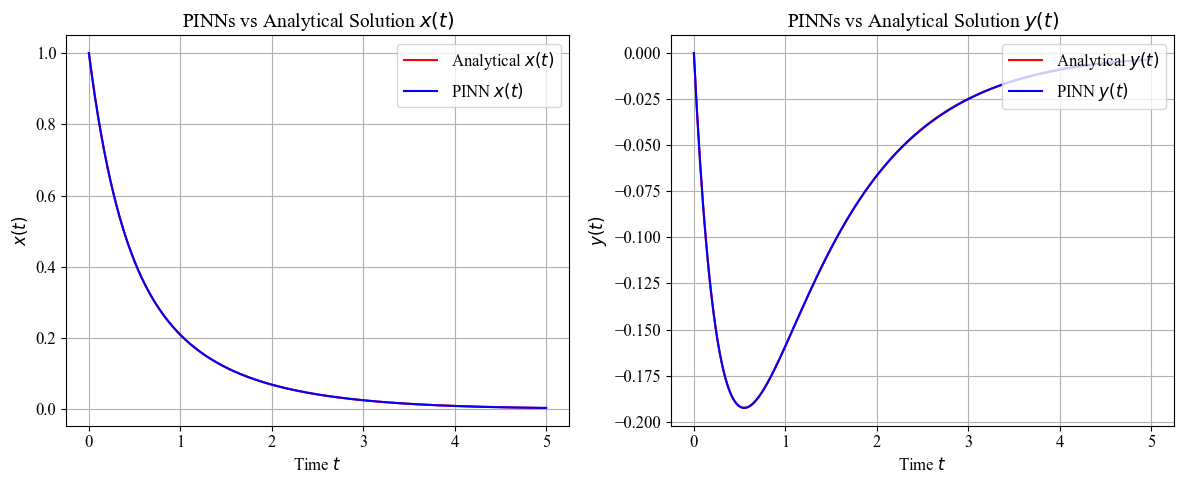

In [7]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_test, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_test, x_pred, label=r'PINN $x(t)$', color='blue')
plt.title(r'PINNs vs Analytical Solution $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_test, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_test, y_pred, label=r'PINN $y(t)$', color='blue')
plt.title(r'PINNs vs Analytical Solution $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

# Data fitting with PINN
## Now generate random noise to similate real data

In [8]:
def generate_noisy_data(t_values, noise_scale=0.05, seed=None):
    """
    Generates noisy data for the solution of two first-order ODEs.

    Parameters:
    - t_values (array-like): Time values for the solution.
    - noise_scale (float): Standard deviation of the Gaussian noise (default: 0.05).
    - seed (int, optional): Seed for the random number generator for reproducibility.

    Returns:
    - t_values (ndarray): Input time values.
    - x_noisy (ndarray): Noisy data for x_t.
    - y_noisy (ndarray): Noisy data for y_t.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Get the exact solution
    x_exact, y_exact = solution(t_values)
    
    # Add Gaussian noise
    x_noisy = x_exact + np.random.normal(scale=noise_scale, size=x_exact.shape)
    y_noisy = y_exact + np.random.normal(scale=noise_scale/2, size=y_exact.shape)
    
    return x_noisy, y_noisy

# Example usage:
t_noisy = np.linspace(0, 5, 50)  # Generate time values
x_noisy, y_noisy = generate_noisy_data(t_noisy, noise_scale=0.05, seed=42)

# Print a sample of the noisy data
for i in range(5):
    print(f"t={t_noisy[i]:.2f}, x_noisy={x_noisy[i]:.4f}, y_noisy={y_noisy[i]:.4f}")

t=0.00, x_noisy=1.0248, y_noisy=0.0081
t=0.10, x_noisy=0.8127, y_noisy=-0.0930
t=0.20, x_noisy=0.7111, y_noisy=-0.1536
t=0.31, x_noisy=0.6439, y_noisy=-0.1533
t=0.41, x_noisy=0.4677, y_noisy=-0.1597


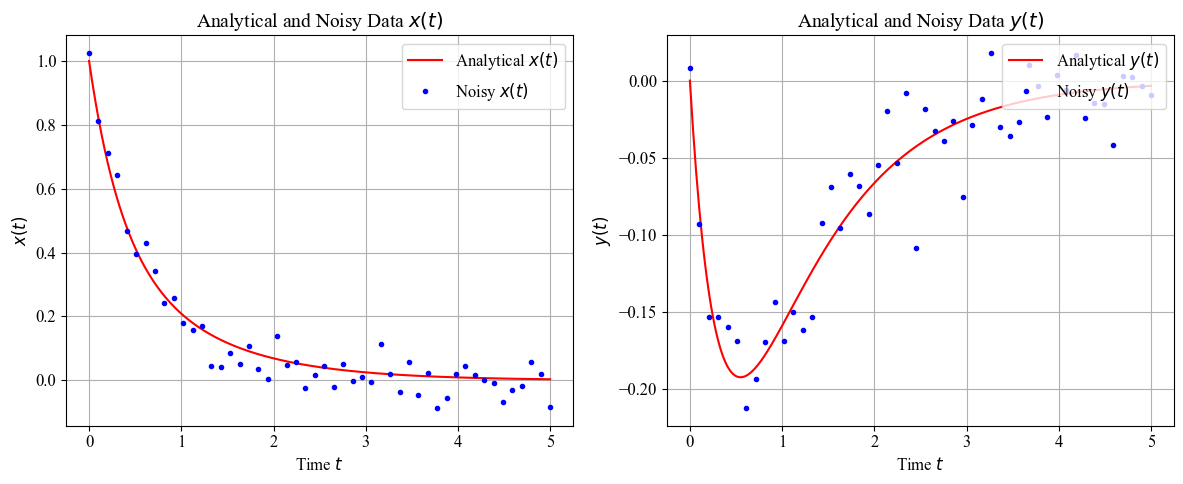

In [9]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_test, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_noisy, x_noisy, 'b.', label=r'Noisy $x(t)$')
plt.title(r'Analytical and Noisy Data $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_test, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_noisy, y_noisy, 'b.', label=r'Noisy $y(t)$')
plt.title(r'Analytical and Noisy Data $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

### Create the Data loss function

In [10]:
def loss_data(data, pred):
    """
    Data Loss Function: Computes the mean squared error (MSE)
    between data and predictions across all dimensions.
    
    Parameters:
    - data (torch.Tensor): Ground truth values.
    - pred (torch.Tensor): Predicted values.

    Returns:
    - torch.Tensor: The computed MSE loss.
    """
    # Compute mean squared error across all dimensions
    loss_data = torch.mean((data - pred) ** 2)
    return loss_data

## Compare data loss with analytical solution
The data loss for the generated data as compared to the analytical data is:

In [11]:
def to_tensor(array, dtype=torch.float32):
    """
    Converts input to a PyTorch tensor if it's not already a tensor.
    """
    if isinstance(array, torch.Tensor):
        return array
    return torch.tensor(array, dtype=dtype)

# Convert numpy arrays to PyTorch tensors, if necessary
x_noisy_tensor = to_tensor(x_noisy)
y_noisy_tensor = to_tensor(y_noisy)

# Compute the noisy solution
x_noisy_sol, y_noisy_sol = solution(t_noisy)
x_noisy_sol_tensor = to_tensor(x_noisy_sol)
y_noisy_sol_tensor = to_tensor(y_noisy_sol)

# Stack tensors along the last dimension
data_noise = torch.stack([x_noisy_tensor, y_noisy_tensor], dim=-1)
sol_noise= torch.stack([x_noisy_sol_tensor, y_noisy_sol_tensor], dim=-1)

# Compute the loss
print(f"Data loss wrt analytical soln: {loss_data(data_noise, sol_noise).item():.8f}")

# Test the model
t_noisy_tensor = torch.tensor(t_noisy.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_noisy_tensor)
    x_noisy_pred, y_noisy_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()
pred_noisy = torch.stack([to_tensor(x_noisy_pred), to_tensor(y_noisy_pred)], dim=-1)
print(f"Data loss wrt predicted NN soln: {loss_data(data_noise, pred_noisy).item():.8f}")



Data loss wrt analytical soln: 0.00136564
Data loss wrt predicted NN soln: 0.00136472


# Now retrain the PINN on the provided data

This time I will include the data as the source of information and the data loss as another term.

## New Set up
1. Define a new total loss function (TLF)
2. Define a new train funciton that uses the new TLF.

In [12]:
def loss_fn(model, t, data):
    """ Total Loss Function """
    # Enable gradient tracking
    t.requires_grad_(True)

    # Forward pass
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # Compute gradients dx/dt and dy/dt
    dxdt = torch.autograd.grad(outputs=x, inputs=t,
                                grad_outputs=torch.ones_like(x),
                                create_graph=True)[0]
    dydt = torch.autograd.grad(outputs=y, inputs=t,
                                grad_outputs=torch.ones_like(y),
                                create_graph=True)[0]

    # Residual ODEs
    res_x = dxdt + 2 * x + y
    res_y = dydt + x + 2 * y
    loss_residuals = torch.mean(res_x ** 2) + torch.mean(res_y ** 2)

    # Initial Conditions (IC) Loss
    ICx = (x[0] - 1) ** 2
    ICy = (y[0] - 0) ** 2
    loss_IC = ICx + ICy

    # Data loss    
    pred = torch.stack([to_tensor(x), to_tensor(y)], dim=-1)
    data_loss = loss_data(data, pred)

    # Total loss
    loss = loss_residuals + loss_IC + data_loss

    return loss

def train(model, t, epochs, optimizer, data):
    for epoch in range(epochs):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the loss
        loss = loss_fn(model, t, data)
        
        # Backpropagation
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Print loss periodically
        if epoch % 500 == 0:
            print(f"Epoch {epoch} Loss: {loss.item()}")



## Run the model

In [13]:
# Run our model
model = PINN()

# Define the optimizer
# optimizer = tf.keras.optimizer.Adam(learning_rate=0.001) # control rate
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Control rate

# Define domain (t ∈ [0, 5]) -- "Collection Points"
# t = tf.convert_to_tensor(np.linspace(0,5,100)[:, None], dtype=tf.float32)
# t = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
t = t_noisy_tensor

# Train the model
train(model, t, epochs=4000, optimizer=optimizer, data=data_noise)

# Test the model
t_test = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_test)
    x_pred, y_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()

Epoch 0 Loss: 1.2554242610931396
Epoch 500 Loss: 0.05410424619913101
Epoch 1000 Loss: 0.05410066246986389
Epoch 1500 Loss: 0.05399477481842041
Epoch 2000 Loss: 0.053988177329301834
Epoch 2500 Loss: 0.053984567523002625
Epoch 3000 Loss: 0.0539839006960392
Epoch 3500 Loss: 0.05398096889257431


## Visualize

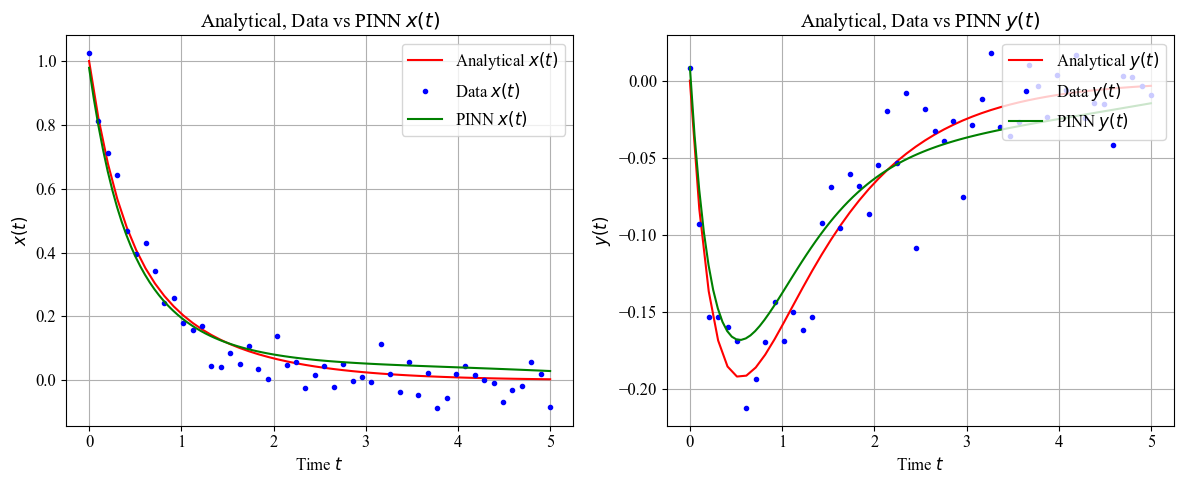

In [14]:
# Compare results:
x_true, y_true = solution(t_noisy)

plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_noisy, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_noisy, x_noisy, 'b.', label=r'Data $x(t)$')
plt.plot(t_test, x_pred, 'g-', label=r"PINN $x(t)$")
plt.title(r'Analytical, Data vs PINN $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_noisy, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_noisy, y_noisy, 'b.', label=r'Data $y(t)$')
plt.plot(t_test, y_pred, 'g-', label=r"PINN $y(t)$")
plt.title(r'Analytical, Data vs PINN $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

## Now increase the epochs
The purpose here is to see if we can get better fits by increasing the number of training epochs.  As will be shown below in the results, it is possible to run through and past the best solution (at least visually).

In [15]:
# Run our model
model = PINN()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Control rate

# Train the model
train(model, t, epochs=50000, optimizer=optimizer, data=data_noise)

# Test the model
t_test = torch.tensor(np.linspace(0, 5, 100).reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    predictions = model(t_test)
    x_pred, y_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()

Epoch 0 Loss: 1.006742000579834
Epoch 500 Loss: 0.05404869094491005
Epoch 1000 Loss: 0.054004378616809845
Epoch 1500 Loss: 0.05399105325341225
Epoch 2000 Loss: 0.05398745834827423
Epoch 2500 Loss: 0.053977612406015396
Epoch 3000 Loss: 0.0539737232029438
Epoch 3500 Loss: 0.054041020572185516
Epoch 4000 Loss: 0.05396750569343567
Epoch 4500 Loss: 0.0539645254611969
Epoch 5000 Loss: 0.05396908521652222
Epoch 5500 Loss: 0.05395779013633728
Epoch 6000 Loss: 0.053954027593135834
Epoch 6500 Loss: 0.05424361303448677
Epoch 7000 Loss: 0.05394478142261505
Epoch 7500 Loss: 0.05393902584910393
Epoch 8000 Loss: 0.05396103486418724
Epoch 8500 Loss: 0.05391525477170944
Epoch 9000 Loss: 0.05381889268755913
Epoch 9500 Loss: 0.04555867984890938
Epoch 10000 Loss: 0.042781755328178406
Epoch 10500 Loss: 0.04259542375802994
Epoch 11000 Loss: 0.042573072016239166
Epoch 11500 Loss: 0.04257200285792351
Epoch 12000 Loss: 0.04257683455944061
Epoch 12500 Loss: 0.04261568561196327
Epoch 13000 Loss: 0.04256960749626

## Visualize

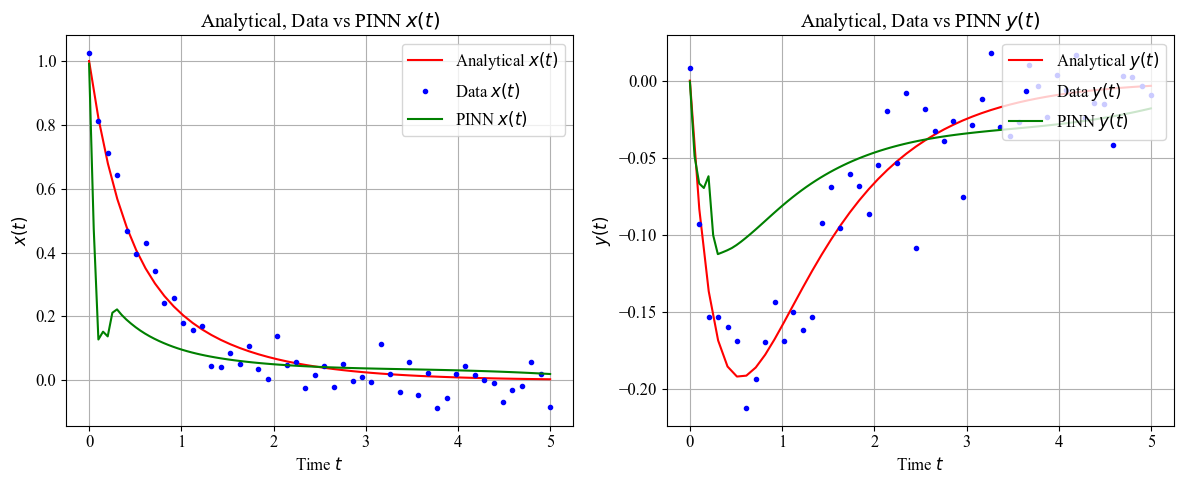

In [16]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_noisy, x_true, label=r'Analytical $x(t)$', color='red')
plt.plot(t_noisy, x_noisy, 'b.', label=r'Data $x(t)$')
plt.plot(t_test, x_pred, 'g-', label=r"PINN $x(t)$")
plt.title(r'Analytical, Data vs PINN $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.subplot(1,2,2)
plt.plot(t_noisy, y_true, label=r'Analytical $y(t)$', color='red')
plt.plot(t_noisy, y_noisy, 'b.', label=r'Data $y(t)$')
plt.plot(t_test, y_pred, 'g-', label=r"PINN $y(t)$")
plt.title(r'Analytical, Data vs PINN $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()

This is an interesting finding when I increased the number of epochs significantly.  It seems like the data in my example is highly populuated towards the higher numbers and causes the model to find solutions that are more favorable for that domain and allows a poor fit for the lesser number of data points on the lower domain values.

In a real problem, we will normalize the data with zero mean and unit variance which should help in this problem.  But in real life, we may have skewed data that is more populated unequally for different regions of the observation domain.

Regardless, I think this example serves as a reasonable starting point for applying the PINN method to fit data that is governed by physical laws of nature.

# Refactor the code and re-run
To optimize and streamline the given PINN implementation, here's an enhanced version utilizing more PyTorch features.

**Key Enhancements and Changes Made**:
- Integrated PINN Class with Proper Structure: The model is now a single class with clear layers, including input, hidden, and output layers.
- Simplified Loss Function: Utilizes PyTorch's built-in nn.MSELoss() for data loss computation and automates gradient calculation using torch.autograd.grad, which is more efficient than manual computation.
- Efficient ODE Handling: Residuals are computed directly without manually separating the terms, leveraging the computed gradients.
- Data Loading with DataLoader: Uses PyTorch's DataLoader to handle batches, improving memory efficiency and training speed.
- Regularization Techniques: Added dropout in the hidden layers for better regularization.
- Model Testing in a Clean Manner: The test method returns predictions without gradient computation to avoid unnecessary computations.
- Improved Code Structure with Classes: Separates concerns into a PINNTrainer class, making code more modular and easier to maintain.
- Documentation and Readability: Added comments and structured the code for clarity, making it easier to understand and modify.
- Error Handling: Uses proper tensor operations and ensures that data is on the correct device (e.g., GPU if applicable).
- Optimization of Initial Conditions: Fixed initial conditions are used but can be modified based on specific problem requirements.

**Implementation Insights:**
- The enhanced code uses PyTorch's optimized functions for gradient computation, leading to better performance.
- DataLoader helps in efficient batch processing, which is crucial for large datasets.
Regularization layers like dropout help prevent overfitting by reducing connectivity during training.
- The PINN structure allows the model to learn the underlying dynamics of ODEs while respecting initial conditions and residual equations.
- This implementation provides a cleaner, more efficient, and maintainable approach to solving ODEs using PINNs in PyTorch.

In [17]:
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from pinn_models import PINN, PINNDataset, PINNTrainer, to_tensor

def print_stats(x_pred, y_pred, x_test_sol, y_test_sol):
        # Statistics
        f1_score_y, accuracy_score_y, roc_auc_score_y = (
            f1_score(y_test_sol, y_pred),
            accuracy_score(y_test_sol, y_pred),
            roc_auc_score(y_test_sol, y_pred))
        f1_score_x, accuracy_score_x, roc_auc_score_x = (
            f1_score(x_test_sol, x_pred),
            accuracy_score(x_test_sol, x_pred),
            roc_auc_score(x_test_sol, x_pred))
        f1_tot = np.mean(f1_score_x, f1_score_y)
        acc_tot = np.mean(accuracy_score_x, accuracy_score_y)
        rocauc_tot = np.mean(roc_auc_score_x, roc_auc_score_y)
        print("Test predictions (x):")
        print(f"     F1:        {f1_score_x:.5f}")
        print(f"     Accuracy:  {accuracy_score_x:.5f}")
        print(f"     ROC AUC:   {roc_auc_score_x:.5f}")
        print("Test predictions (y):")
        print(f"     F1:        {f1_score_y:.5f}")
        print(f"     Accuracy:  {accuracy_score_y:.5f}")
        print(f"     ROC AUC:   {roc_auc_score_y:.5f}")
        print("Test predictions (total):")
        print(f"     F1:        {f1_tot:.5f}")
        print(f"     Accuracy:  {acc_tot:.5f}")
        print(f"     ROC AUC:   {rocauc_tot:.5f}")
        
# Example usage:
def main(batch_size: int = 50, num_workers: int = 0):
    # Define training dataset
    noisy_data = np.array([t_noisy, x_noisy, y_noisy]).T
    print(f"Dimensions of noisy_data: {noisy_data.shape}")
    X_train, X_test, train_t, test_t = train_test_split(
        noisy_data[:,:2], noisy_data[:,2], test_size=0.25, random_state=42)
    train_x = X_train[:,0]
    train_y = X_train[:,1]

    # print(f"Dimensions of x_noisy: {x_noisy.shape}")
    # print(f"Dimensions of y_noisy: {y_noisy.shape}")
    # print(f"Dimensions of X_train: {X_train.shape}")
    # print(f"Dimensions of train_x: {train_x.shape}")
    # print(f"Dimensions of X_test: {X_test.shape}")

    train_dataset = PINNDataset(train_t, train_x, train_y)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers  # Adjust based on available CPUs/GPUs
    )

    # Define test dataset (if needed)
    test_x = X_test[0,:]
    test_y = X_test[1,:]

    test_dataset = PINNDataset(test_t, test_x, test_y)
    test_loader = DataLoader(
        test_dataset,
        batch_size=100,
        shuffle=False,
        num_workers=num_workers
    )

    # Initialize model and optimizer
    model = PINN(hidden_size=64, output_size=2).to(torch.float32)
    optimizer = Adam(model.parameters(), lr=0.001)

    # Training
    trainer = PINNTrainer(model, optimizer, train_loader, test_loader)
    trainer.train()

    # Testing
    x_pred, y_pred, x_test_sol, y_test_sol = trainer.test()
    # print(f"Test predictions: x={x_pred}, y={y_pred}")
    
    print_stats(x_pred, y_pred, x_test_sol, y_test_sol)

# if __name__ == "__main__":
#     main()


In [ ]:
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from pinn_models import PINN, PINNDataset, PINNTrainer

# In your main function or where you define data
num_workers = 0
batch_size= 50
# Define training dataset
noisy_data = np.array([t_noisy, x_noisy, y_noisy]).T
print(f"Dimensions of noisy_data: {noisy_data.shape}")
X_train, X_test, train_t, test_t = train_test_split(
    noisy_data[:,:2], noisy_data[:,2], test_size=0.25, random_state=42)
train_x = X_train[:,0]
train_y = X_train[:,1]

train_t = train_t.reshape(-1, 1)  # Ensure train_t has shape (batch_size, 1)
test_t = test_t.reshape(-1, 1)    # Ensure test_t has shape (batch_size, 1)

# print(f"Dimensions of x_noisy: {x_noisy.shape}")
# print(f"Dimensions of y_noisy: {y_noisy.shape}")
# print(f"Dimensions of X_train: {X_train.shape}")
# print(f"Dimensions of train_x: {train_x.shape}")
# print(f"Dimensions of X_test: {X_test.shape}")

train_dataset = PINNDataset(train_t, train_x, train_y)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers  # Adjust based on available CPUs/GPUs
)

# Define test dataset (if needed)
test_x = X_test[:,0]
test_y = X_test[:,1]

test_dataset = PINNDataset(test_t, test_x, test_y)
test_loader = DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=num_workers
)

# Initialize model and optimizer
model = PINN(hidden_size=64, output_size=2).to(torch.float32)
optimizer = Adam(model.parameters(), lr=0.001)

# Training
trainer = PINNTrainer(model, optimizer, train_loader, test_loader)
trainer.train()

# Testing
x_pred, y_pred, x_test_sol, y_test_sol = trainer.test()
# print(f"Test predictions: x={x_pred}, y={y_pred}")
    
print_stats(x_pred, y_pred, x_test_sol, y_test_sol)





Dimensions of noisy_data: (50, 3)
Batch size: 37
Loss: residual = 0.557483
Loss: IC = 1.527229
Loss: Data = 9.181489
Epoch 0 Loss: 11.266201
Batch size: 37
Loss: residual = 0.250958
Loss: IC = 1.082465
Loss: Data = 8.691416
Batch size: 37
Loss: residual = 0.079204
Loss: IC = 1.077237
Loss: Data = 8.152256
Batch size: 37
Loss: residual = 0.061741
Loss: IC = 0.788005
Loss: Data = 7.792852
Batch size: 37
Loss: residual = 0.151936
Loss: IC = 0.801853
Loss: Data = 7.399805
Batch size: 37
Loss: residual = 0.283361
Loss: IC = 0.626722
Loss: Data = 7.130752
Batch size: 37
Loss: residual = 0.441252
Loss: IC = 0.514391
Loss: Data = 6.862203
Batch size: 37
Loss: residual = 0.669533
Loss: IC = 0.450821
Loss: Data = 6.530175
Batch size: 37
Loss: residual = 0.789864
Loss: IC = 0.334528
Loss: Data = 6.289080
Batch size: 37
Loss: residual = 0.974776
Loss: IC = 0.201826
Loss: Data = 6.168315
Batch size: 37
Loss: residual = 1.079196
Loss: IC = 0.148614
Loss: Data = 5.964267
Batch size: 37
Loss: residual

IndexError: index 2 is out of bounds for dimension 0 with size 2

**THIS SECTION IS NOT READY**
Gathering ideas.


# Predict last data point
At this point, I would like to see if we can create a model to predict the last data point $(x,y)_f$.  To do this, I need to change the structure of the neural netowrk.

## Model a PINN class to predict last data point

### Step-by-Step Explanation:

When you define a PINN model with a specified sequence length, such as model = PINN(`seq_length=5`), you are instructing the model to process multiple time points simultaneously during both training and prediction. Here's how this works:

1. Understanding Sequence Length in PINN Models:

The `seq_length` parameter specifies that the model should consider a fixed number of consecutive time steps when processing data.
For example, setting `seq_length=5` means each input to the model consists of five consecutive time points.

2. Training Process:

During training, the model processes these five time points together.
It uses these five inputs to learn patterns or relationships that help it predict future values or other outputs associated with the last time step in the sequence.

3. Sliding Window Mechanism:

    - In effect, the model slides along the sequence, moving from one window of five time points to the next.
    - This sliding window approach allows the model to learn dependencies that might exist between different parts of the sequence.

4. Forward Pass and Output:

    - The input tensor is typically three-dimensional (batch size × time steps × features).
    - For a `seq_length` of 5, the input is reshaped to be five-dimensional (batch size × `seq_length` × features), allowing the model to process each time step within the window.
    - After processing through the network layers, the output is typically one-dimensional per time step in the sequence.

5. Loss Calculation and Backpropagation:

    - The loss function usually computes a measure of error between predicted values and actual targets for each time step in the sequence.
    - Backpropagation propagates gradients through the entire sequence, allowing the model to update weights based on all processed time steps simultaneously.

6. Prediction Process:

    - During prediction, if the test data has the same structure as the training input (aligned with the specified `seq_length`), the model can process these sequences in chunks of five time points.
    - The predictions are typically generated for each time step within each window. If needed, these predictions can be combined or aggregated to produce a final output.

7. Considerations and Adjustments:

    - Sequence Alignment: Ensure that test data aligns with the training data structure, maintaining consistent sequence length during prediction.
    - Model Capacity: Depending on the complexity of patterns in the data, you might need to adjust the number of layers or hidden units in the model.
    - Gradient Flow: The sliding window approach can affect gradient flow. Proper initialization and learning rate selection are essential for stable training.

8. Practical Implementation:

    - Start with a small `seq_length` (e.g., 2 or 3) to understand how the model processes sequences.
    - Gradually increase the sequence length as needed, monitoring model performance and training stability.
    - Utilize available tools and libraries that support sequence-to-sequence models, ensuring compatibility with the chosen framework.

9. Documentation and Resources:

    - Consult documentation or tutorials specific to PINN networks for detailed implementation guides and best practices in sequence processing.
    - Explore forums or communities where users discuss PINN model implementations, as others may have encountered similar challenges and solutions.

### Conclusion:
Setting `model = PINN(seq_length=5)` enables the model to process five consecutive time points at once during training. It slides over the data, learning relationships across these steps, and generates predictions for each time point in the sequence. Proper alignment of test data and careful adjustment of hyperparameters are crucial for effective model performance.

In [95]:
class PINN(nn.Module):
    """ PINN setup
    
    Key Points:
    1. Dynamic Masking: During training, the model processes only a subset of 
       the sequence (excluding the last window_size steps). This prevents 
       overfitting to the end of the sequence.
    2. Focused Loss Calculation: The loss is computed only on the predictions 
       at the last time step, ensuring that the model learns from all preceding 
       steps but focuses on accurate prediction at the desired point.
    3. Teacher Forcing (Optional): During testing, you can choose to remove the 
       masking and allow the model to make predictions without the constraint 
       of excluding certain time steps.

    Usage:
    1. Training

        ``` python
        # Initialize dataset with sufficient length
        train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Training loop
        for epoch in range(num_epochs):
            for inputs, labels in train_loader:
                loss = model.training_step(inputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        ```
        
    2. Testing

        ``` python
        # Prepare test data (sequence length as required by model)
        test_t, test_x, test_y = prepare_test_data(seq_length=model.seq_length)

        # Test loop
        outputs = model.test_step(test_t)
        # Evaluate predictions at the last time step
        predicted_x = outputs[:, -1]
        predicted_y = outputs[:, -1]
        ```
    """
    def __init__(self, seq_length=5, window_size=2):
        super(PINN, self).__init__()
        self.seq_length = seq_length
        self.window_size = window_size
        
        # Input processing layer with sequence length
        self.input_layer = nn.Linear(seq_length * 64, 64)
        self.tanh = nn.Tanh()
        
        # First hidden layer
        self.hidden1 = nn.Sequential(
            nn.Linear(64, 64),
            self.tanh,
        )
        
        # Output layer for x and y
        self.output_layer = nn.Linear(64, 2)  # Outputs x(t), y(t)
        
    def forward(self, t):
        # Exclude last `window_size` time steps during training (dynamic masking)
        mask = torch.ones(t.size(1), dtype=torch.bool)
        mask[:, -self.window_size:] = False
        t_filtered = []
        for i in range(t.size(1)):
            if mask[:, i]:
                t_filtered.append(t[:, i])
            else:
                t_filtered.append(None)  # Placeholder for excluded steps
        t_filtered = torch.stack([t[:, i] for i, val in enumerate(t_filtered) if val is not None], dim=1)
        
        # Reshape to (seq_length, batch_size)
        t = t_filtered.permute(1)
        
        # Flatten the sequence for processing
        hidden = self.input_layer(t.view(-1))  # Shape: (batch_size * seq_length, 64)
        hidden = hidden.view(batch_size, -1)  # Reshape back to (batch_size, 64)
        
        # Process through first hidden layer
        hidden = self.hidden1(hidden)
        
        # Output predictions for x and y
        output = self.output_layer(hidden)
        return output
        
    def training_step(self, batch):
        t, x, y = batch
        # Exclude last `window_size` time steps from input during training
        mask = torch.ones(t.size(1), dtype=torch.bool)
        mask[:, -self.window_size:] = False
        filtered_t = []
        for i in range(t.size(1)):
            if not mask[:, i]:
                filtered_t.append(t[:, i])
            else:
                filtered_t.append(None)
        filtered_t = torch.stack([t[:, i] for i, val in enumerate(filtered_t) if val is not None], dim=1)
        
        # Forward pass
        t = filtered_t.permute(1)
        hidden = self.input_layer(t.view(-1))
        hidden = hidden.view(batch_size, -1)
        output = self.output_layer(hidden)
        
        # Compute loss only on the last time step
        criterion = nn.MSELoss()
        loss = criterion(output[:, -1], x[:, -1])
        return loss
        
    def test_step(self, t):
        # Remove the masking for testing (use original sequence length)
        t = t.permute(1)
        hidden = self.input_layer(t.view(-1))
        hidden = hidden.view(batch_size, -1)
        output = self.output_layer(hidden)
        return output


## Use sequence sliding input window for allowed training data


## Use window data gap to ignore data in training


## Perform 2-class classification for last point prediction


## Expand last point prediction to area prediction


### Example Graph represent probabilities

/var/folders/bj/ncr1n7_13gv1_cr07lsbnl7h0000gn/T/ipykernel_3617/3109742726.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


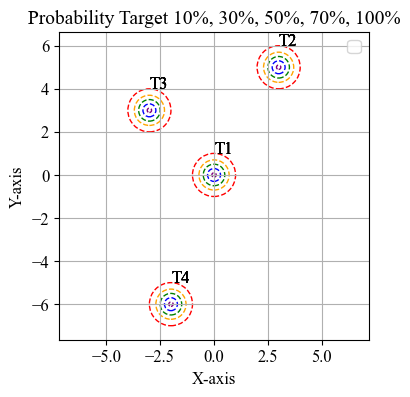

In [96]:
# Create a figure with an 8x8 inch size
plt.figure(figsize=(4, 4))
ax = plt.gca()#axes()#([0.05, 0.05, 1, 1])

# Define radii for each probability level (as fractions of the unit circle)
radii = [0.1, 0.3, 0.5, 0.7, 1.0]

# Assign colors to each circle
colors = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#ff00ff']
color_map = {
    0.1: 'purple',
    0.3: 'blue',
    0.5: 'green',
    0.7: 'orange',
    1.0: 'red'
}
xy_circles = [(0,0), (3,5), (-3,3), (-2, -6)]
xy_names = ['T1', 'T2', 'T3', 'T4']

# change default range so that new circles will work
ax.set_xlim((min([c[0] for c in xy_circles])-radii[-1]-radii[0], 
             max([c[0] for c in xy_circles])+radii[-1]+radii[0]))
ax.set_ylim((min([c[1] for c in xy_circles])-radii[-1]-radii[0], 
             max([c[1] for c in xy_circles])+radii[-1]+radii[0]))

for n in range(len(xy_circles)):
    for r in radii:
        # Draw each circle as a dashed line outline without filling
        circle = plt.Circle(xy_circles[n], r, linestyle='--', fill=False, color=color_map[r])#edgecolor=colors[radii.index(r)])
        ax.add_patch(circle)
        plt.text(xy_circles[n][0], xy_circles[n][1]+radii[-1], xy_names[n])

# Set background colors for a clean look
ax.set_facecolor('white')
ax.axis('equal')

# Add labels and title
mytitle = "Probability Target"
for r in radii:
    mytitle+=f" {(r*100):.0f}%,"
mytitle=mytitle[:-1]
plt.title(mytitle, fontsize=14)
plt.grid()
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the graph
# plt.savefig('cicles.png')
plt.show()
